Name: Yile Wang

netid: yxw190015

In [1]:
import networkx as nx
import sys
sys.path.append('../d3networkx/')
import d3networkx as d3nx
from d3graph import D3Graph, D3DiGraph
from numpy import *
from numpy.linalg import eig,norm
import matplotlib.pyplot as plt
plt.ioff()
from time import time
from copy import deepcopy
import asyncio
import colorsys
from sklearn import preprocessing
import random

## A summary of lab6

[1]:  "2pts: Correct submission (files, file type, file naming)." . `done`  
[2]:  "6pts: Discuss the effect of the diffusion parameter C." . `Discussed. Gist: The diffusion parameter controls the diffusion speed` .   
[3]:  "20pts: Convergence plot of diffusion process."  `plotted. See convergence plot`.   
[4]:  "20pts: SI plot - at least one plot for each network and 3 different beta values for one network" .  `plotted. Three network, 10 different beta`  
[5]:  "8pts: Discuss the effect of the beta parameter." .   `Discussed. beta is the contagiousness rate`  
[6]:  "20pts: SIR plot - at least one plot for each network and 3 different gamma values for one network" .   `Plotted. Three network, 3 different gamma`   
[7]:  "8pts: Discuss the effect of the gamma parameter relative to the critical value." `Discussed. Gist: gamma is the recovery rate. And it's connected to the largest eigenvalue. It's epidemic threshold`.    
[8]:  "18pts: Plots of activation/infection for each node comparing influence (two ways) and SIR." .   `Plotted. Independent Cascade, percolation and SIR`   

The following functions assist in coloring nodes based on the value of the state at each node. You will only need to use `color_by_value` - the rest of the functions are helper functions that are used behind the scenes.

In [2]:
def RGBToHTMLColor(rgb_tuple):
    """ convert an (R, G, B) tuple to #RRGGBB """
    hexcolor = '#%02x%02x%02x' % rgb_tuple
    # that's it! '%02x' means zero-padded, 2-digit hex values
    return hexcolor

def HTMLColorToRGB(colorstring):
    """ convert #RRGGBB to an (R, G, B) tuple """
    colorstring = colorstring.strip()
    if colorstring[0] == '#': colorstring = colorstring[1:]
    if len(colorstring) != 6:
        raise ValueError("input #%s is not in #RRGGBB format" % colorstring)
    r, g, b = colorstring[:2], colorstring[2:4], colorstring[4:]
    r, g, b = [int(n, 16) for n in (r, g, b)]
    return (r, g, b)

def color_interp(color1,color2,v,m=0,M=1):
    c1 = array(HTMLColorToRGB(color1))
    c2 = array(HTMLColorToRGB(color2))
    if v > M:
        c = tuple(c2)
    elif v <= m:
        c = tuple(c1)
    else:
        c = tuple( c1 + (c2-c1)/(M-m)*(v-m) ) # linear interpolation of color
        #c = tuple( rint( c1 + (c2-c1)*(1 - exp(-2*(v-m)/(M-m))) ) ) # logistic interpolation of color
        c = (int(c[0]),int(c[1]),int(c[2]))
    return RGBToHTMLColor(c)

def color_by_value(d3,G,x,color1='#FFFFFF',color2='#F57878'):  #color1='#77BEF5'
    interactive = d3.interactive
    d3.set_interactive(False)
    m = 0
    M = 1#0.5
    for n in G.nodes():
        d3.stylize_node(n, d3nx.node_style(size=5,stroke='#494949',fill=color_interp(color1,color2,x[G.node_index(n)],m,M)))
    d3.update()
    d3.set_interactive(interactive)

## Load the network

In [4]:
network1 = 'dolphins'
network2 = 'train'
network3 = 'macaque'

In [14]:
# dolphins
G1 = D3Graph( nx.read_weighted_edgelist(network1+'.edgelist',create_using=nx.Graph) )
A1 = array(nx.adjacency_matrix(G1).todense().T)
N1 = G1.number_of_nodes()

In [8]:
# train
G2 = D3Graph( nx.read_weighted_edgelist(network2+'.edgelist',create_using=nx.Graph) )
A2 = array(nx.adjacency_matrix(G2).todense().T)
N2 = G2.number_of_nodes()

In [5]:
# macaque
G3 = D3Graph( nx.read_weighted_edgelist(network3+'.edgelist',create_using=nx.Graph) )
A3 = array(nx.adjacency_matrix(G3).todense().T)
N3 = G3.number_of_nodes()

In [ ]:
d3 = await d3nx.create_d3nx_visualizer(interactive=False,
                                       node_dstyle=d3nx.node_style(size=5,fill='#FFFFFF',stroke='#494949'),
                                       edge_dstyle=d3nx.edge_style(stroke_width=1.25))

In [ ]:
d3.port

In [ ]:
d3.clear()
d3.set_graph(G3)
d3.update()
d3.set_interactive(True)

## Diffusion

In [19]:
dt = 0.02 # the "infinitesimal" size steps we take to integrate
T = 6 # the end of the simulation time
time = linspace(0,T,int(T/dt)) # the array of time points spaced by dt

Simulating diffusion...

In [ ]:
x = zeros(N1)
x[0] = 1
color_by_value(d3,G1,x)
C=0.5 # C is the diffusion constant
history = zeros((len(time),N1))
for i,t in enumerate(time):
    x += dt*(C*dot(A1,x) - x) # the dynamics
    history[i] = x
    color_by_value(d3,G1,x*100)  # update the visualizer
    await asyncio.sleep(0.1) # wait a little bit so the visualizer has time to update

In [21]:
x = zeros(N1)
x[0] = 1
C=0.5 # C is the diffusion constant

def network_convergence(C, x, A1, dt, time, N1):
    history = zeros((len(time),N1))
    for i,t in enumerate(time):
        x += dt*(C*dot(A1,x) - x) # the dynamics
        history[i] = x
    return history
history = network_convergence(C, x, A1, dt, time, N1)

### [2] Make a comment about this:

When I used different diffusion constant `C`, the speed of diffusion will be different from x[0] node to all other nodes. If the `C` is 1, the diffusion time from one node to the whole network is 8 sec. However, if `C` is 10, the diffusion time is only 1.5 sec. Thus, we can know the `C` is controlling the diffusion speed.

### [3] Make a plot of distance between state x and equilibrium

when time gets large, the equilibrium was related to the eigenvectors of the Laplacian matrix. reuse code from centrality to calculate the eigenvectors of the module.

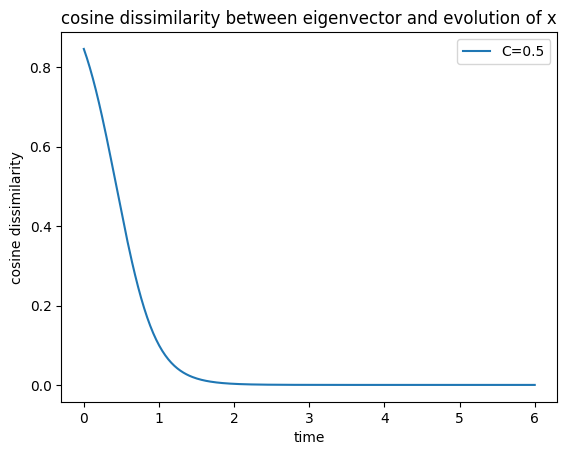

In [22]:
# calculate the eigenvector of the network
eigencentrality_vector = [i for i in nx.eigenvector_centrality(G1).values()]

# define a cosine dissimilarity function
def cosine_dissimilarity(x,y):
    return 1-(dot(x,y)/(norm(x)*norm(y)))

# calculate the cosine similarity between the eigenvector and the history
cosine_dissimilarity_history = [cosine_dissimilarity(eigencentrality_vector,history[i]) for i in range(len(time))]
plt.plot(time,cosine_dissimilarity_history, label="C=0.5")
plt.xlabel('time')
plt.ylabel('cosine dissimilarity')
plt.title('cosine dissimilarity between eigenvector and evolution of x')
plt.legend()
plt.show()



### A comparison between different diffusion parameter `C` at different network

I need to stress that macaque network is a fully connected network, so increasing `C` will cause some weird plot.

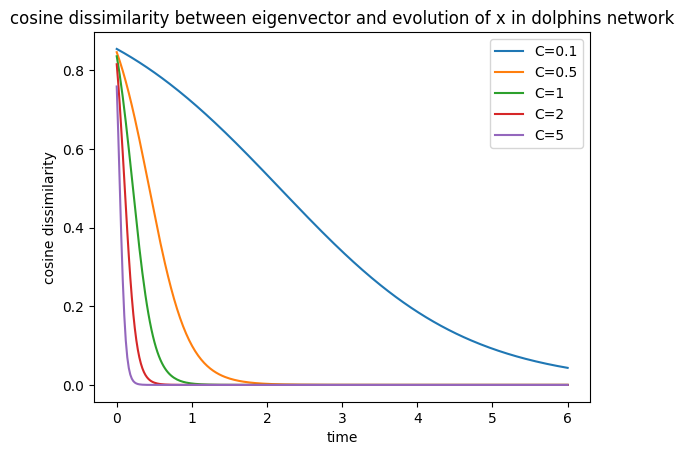

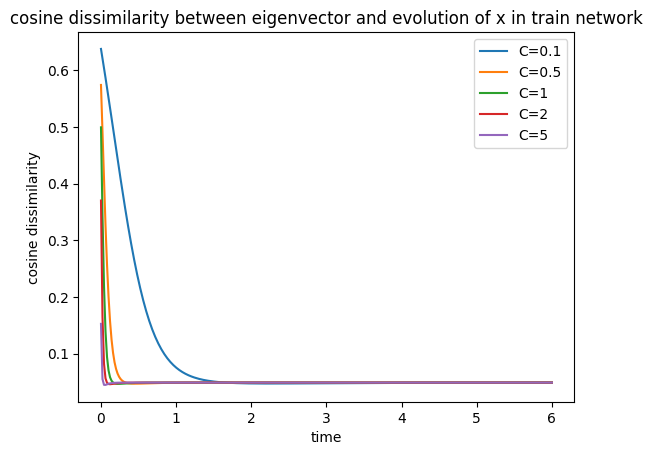

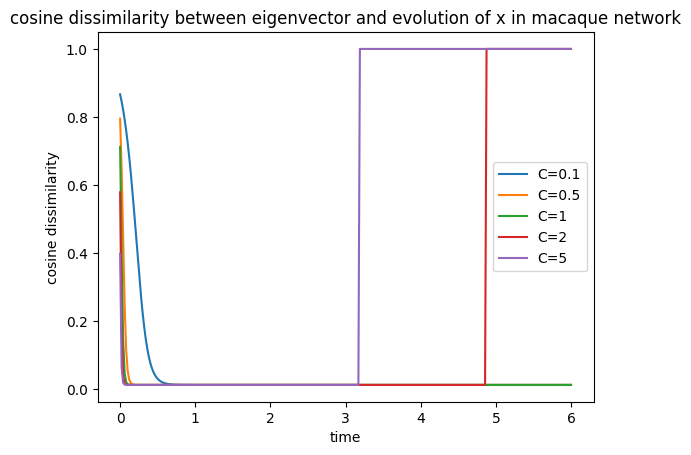

In [23]:
def multiple_network(G1, A1, N1, name):
    # multiple C
    C_list = [0.1, 0.5, 1, 2, 5]
    eigencentrality_vector = [i for i in nx.eigenvector_centrality(G1).values()]
    for C in C_list:
        x = zeros(N1)
        x[0] = 1
        history_c = network_convergence(C, x, A1, dt, time, N1)
        cosine_dissimilarity_history = [cosine_dissimilarity(eigencentrality_vector,history_c[i]) for i in range(len(time))]
        plt.plot(time,cosine_dissimilarity_history, label="C="+str(C))
    plt.xlabel('time')
    plt.ylabel('cosine dissimilarity')
    plt.title(f'cosine dissimilarity between eigenvector and evolution of x in {name} network')
    plt.legend()
    plt.show()

multiple_network(G1, A1, N1, "dolphins")
multiple_network(G2, A2, N2, "train")
multiple_network(G3, A3, N3, "macaque")

## SI Model

### [4] make SI plot
Simulating SI model...  
Make a plot of the expected fraction of infected people over time using a SI infection model.  
Ajust to see how it effects the evolution


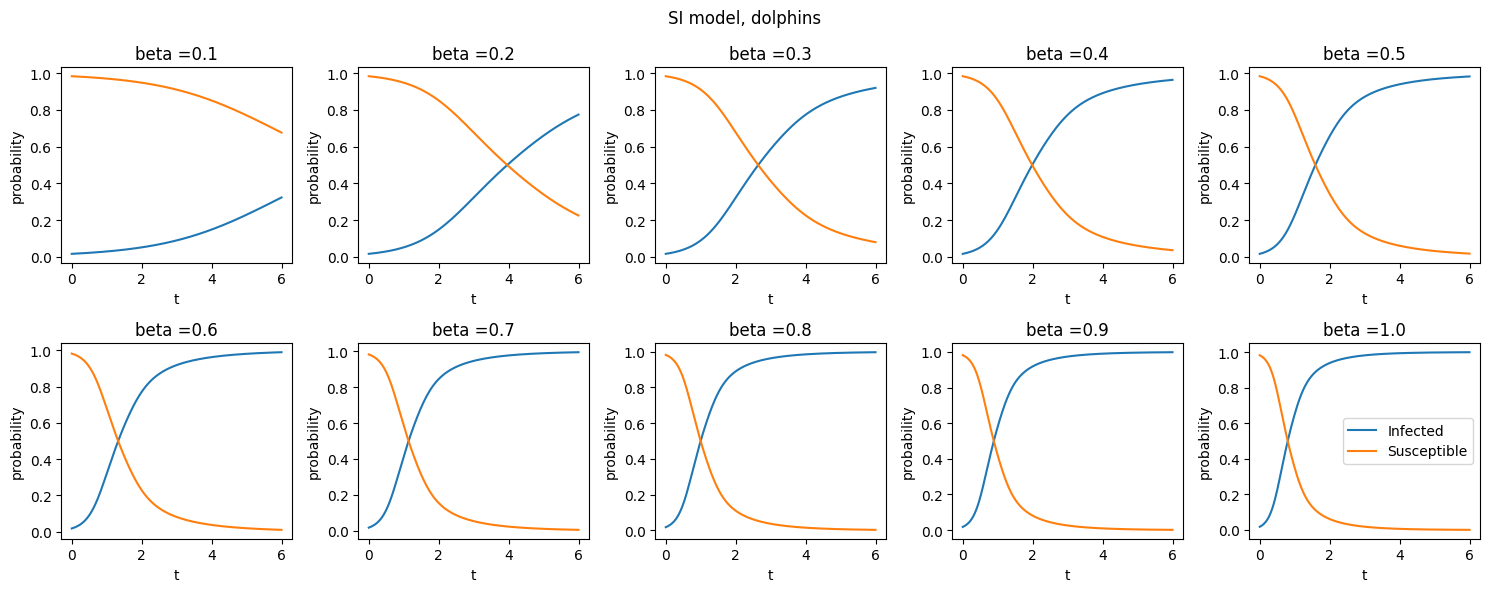

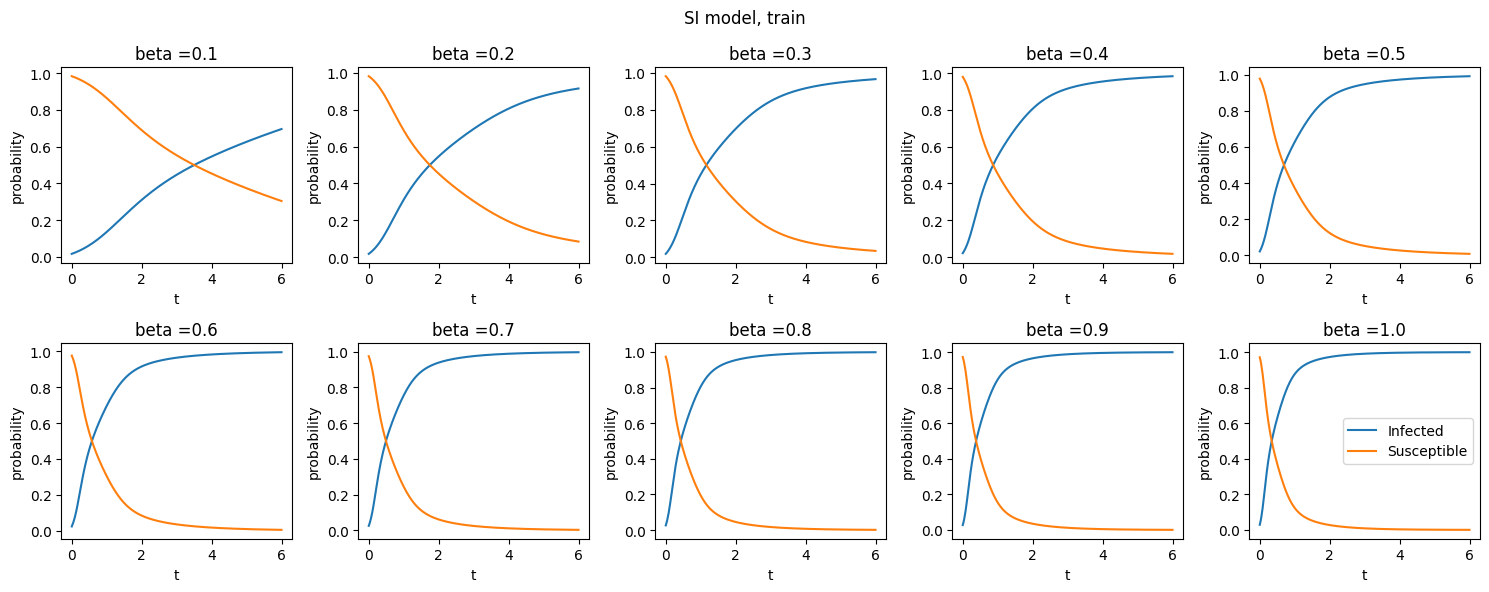

/var/folders/gz/j8z1vy514q51r1gxg3zf8s_h0000gn/T/ipykernel_15021/2208190187.py:12: RuntimeWarning: overflow encountered in multiply
  x += dt*(beta*dot(A,x)*s) # the dynamics
/Users/yat-lok/miniconda3/envs/tvbenv/lib/python3.10/site-packages/numpy/core/_methods.py:180: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims, where=where)


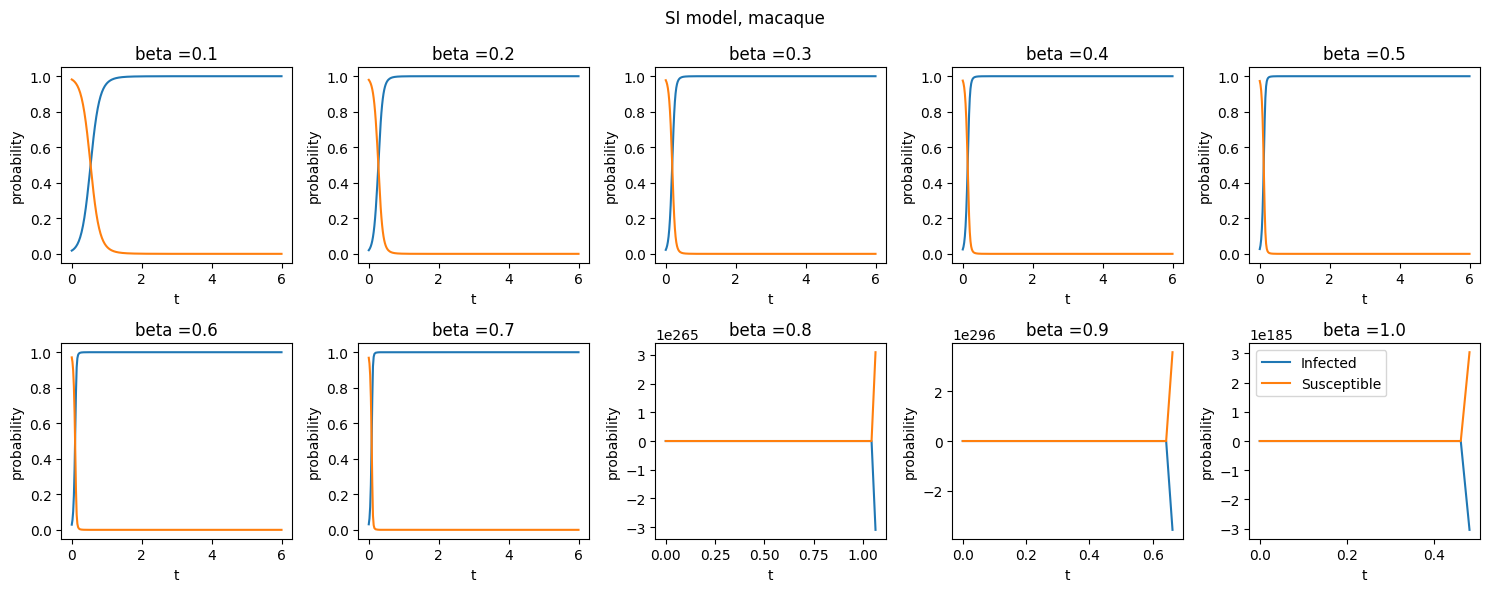

In [24]:
# calculate the SI model for the network
beta = 1
# x is the fraction of infected nodes
# 1-x is the fraction of susceptible nodes


def SI_model(beta, x, s, A, dt, time):
    history_S = []
    history_I = []

    for i,t in enumerate(time):
        x += dt*(beta*dot(A,x)*s) # the dynamics
        s = 1 - x
        history_S.append(mean(s))
        history_I.append(mean(x))
    return history_I, history_S


A_list = [A1, A2, A3]
N_list = [N1, N2, N3]
name_list = ["dolphins", "train", "macaque"]
for A, N, name in zip(A_list, N_list, name_list):
    # Create a 2x5 grid of subplots
    fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(15, 6))
    fig.suptitle(f'SI model, {name}')
    beta_list = arange(0.1, 1.1, 0.1)
    for i, ax in enumerate(axes.flatten()):
        x = zeros(N)
        x[0] = 1
        s = 1- x
        history_I, history_S = SI_model(beta_list[i], x, s, A, dt, time)
        ax.plot(time, history_I, label = 'Infected')
        ax.plot(time, history_S, label = 'Susceptible')
        ax.set_xlabel('t')
        ax.set_ylabel('probability')
        ax.set_title(f'beta ={round(beta_list[i], 3)}')
    plt.tight_layout()
    plt.legend()
    plt.show()

### [5] Discuss effect of beta

Beta will control how quickly the virus will infect all the population. In other words, `beta` is the contagiousness of the disease, or the infection rate of the disease. Large `beta` will lead to a fast spreading of the disease.

## SIR Model

Simulating SIR model...  
plot 
describe and explain the effect. 

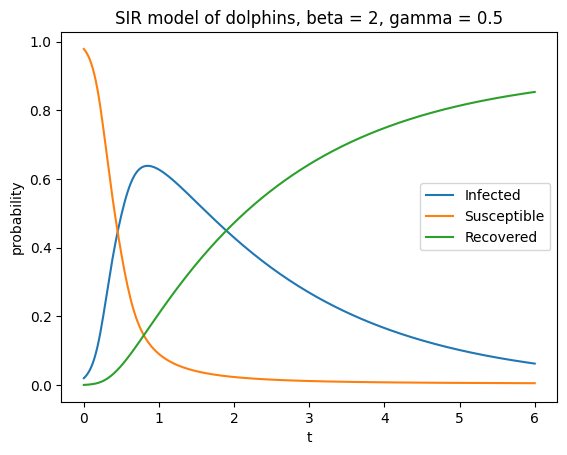

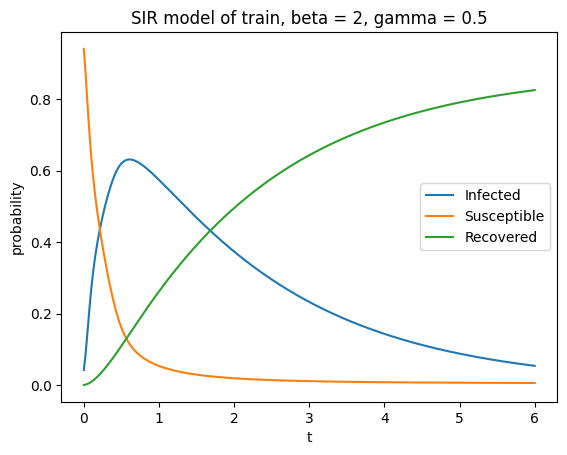

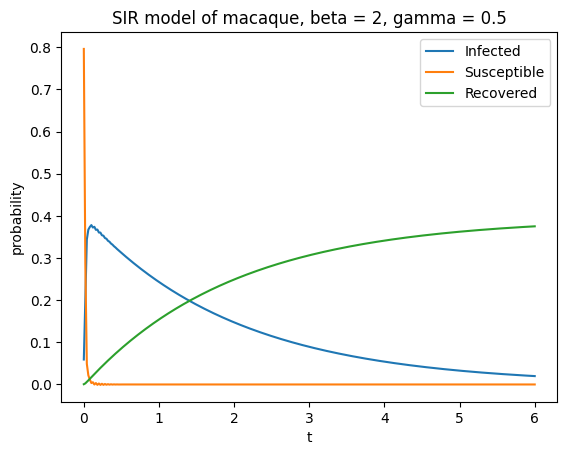

In [25]:
# calculate the SIR model for the network
beta = 2
gamma = 0.5
# x is the fraction of infected nodes
# 1-x is the fraction of susceptible nodes
# r is the fraction of recovered nodes


def SIR_model(beta, gamma, A,N, dt, time):
    history_S = []
    history_I = []
    history_R = []
    x = zeros(N)
    x[0] = 1
    s = 1- x
    r = 1-x-s


    for i,t in enumerate(time):
        x += dt*(beta*dot(A,x)*s - gamma*x) # the dynamics
        s += dt*(-beta*dot(A,x)*s)
        r += dt*(gamma*x)
        history_S.append(mean(s))
        history_I.append(mean(x))
        history_R.append(mean(r))
    return history_I, history_S, history_R


def multiple_SIR(A,N,name):
    history_I, history_S, history_R = SIR_model(beta, gamma, A, N, dt, time)
    plt.plot(time, history_I, label = 'Infected')
    plt.plot(time, history_S, label = 'Susceptible')
    plt.plot(time, history_R, label = 'Recovered')
    plt.xlabel('t')
    plt.ylabel('probability')
    plt.title(f'SIR model of {name}, beta = {beta}, gamma = {gamma}')
    plt.legend()
    plt.show()

for A, N, name in zip(A_list, N_list, name_list):
    multiple_SIR(A, N, name)

### [6] SIR plot with three different gamma

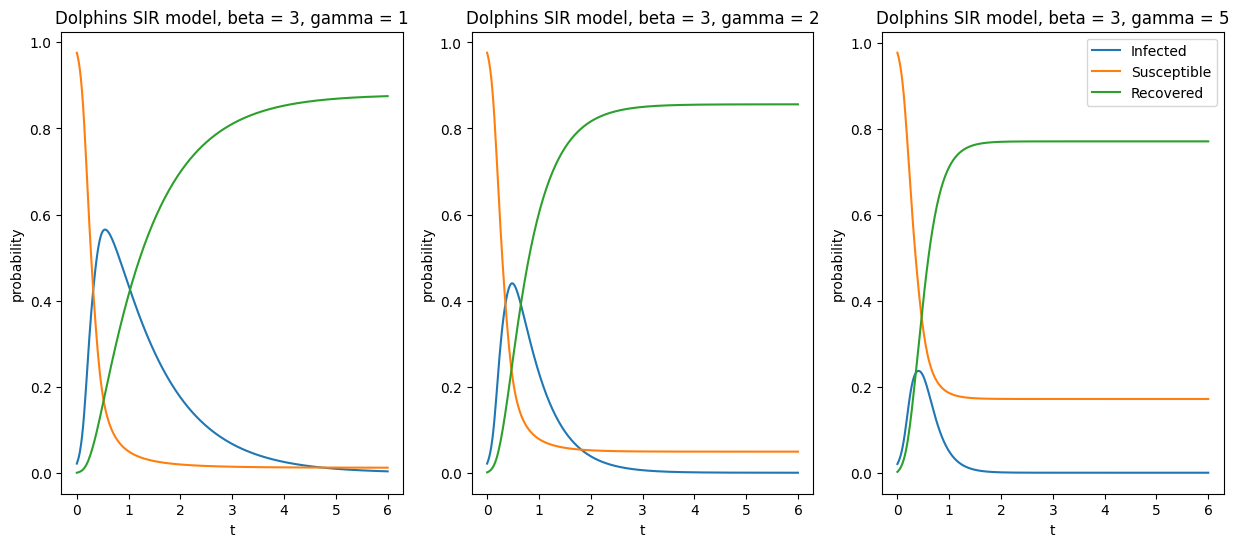

In [39]:
# calculate the SIR model for the network, using dolphins network
beta = 3
gamma_list = [1, 2, 5]

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
for gamma_index, ax in enumerate(axes.flatten()):
    history_I, history_S, history_R = SIR_model(beta, gamma_list[gamma_index], A1,N1, dt, time)
    ax.plot(time, history_I, label = 'Infected')
    ax.plot(time, history_S, label = 'Susceptible')
    ax.plot(time, history_R, label = 'Recovered')
    ax.set_xlabel('t')
    ax.set_ylabel('probability')
    ax.set_title(f'Dolphins SIR model, beta = {beta}, gamma = {gamma_list[gamma_index]}')
plt.legend()
plt.show()


### [7] gamma parameters and critical value. 

Gamma is the recovery rate, which is related to the Epidemic threshold. In equation $\beta \lambda_1 - \gamma = 0$. If the $\lambda$ is larger, it's easier for disease to spread. If it is smaller, it's harder for disease to spread.

As we can see here, the eigenvalue of the macaque network is huge, so it's much easier for disease to spread. When I plot out the macaque network, you can see that it's almost a fully-connected network. There are some center nodes connecting with majority of the other nodes, which makes disease much easier to spread.

In [44]:
### calculate the eigenvalues of the dolphin's network
for A, network in zip(A_list, name_list):
    e = linalg.eigvals(A)

    # largest eigenvalue
    eigen_max = max(e)
    # smallest eigenvalue
    eigen_min = min(e)
    print(f'{network}:')
    print(f'largest eigenvalue is {eigen_max}')
    print(f'smallest eigenvalue is {eigen_min}')




dolphins:
largest eigenvalue is 7.193614015378695
smallest eigenvalue is -3.8210283871620225
train:
largest eigenvalue is 19.486254328914043
smallest eigenvalue is -6.007219839639063
macaque:
largest eigenvalue is 84.00939997048337
smallest eigenvalue is -21.77917042007246


### An example of critical value as eigenvalue in Dolphins network

graph 1: beta = 2, gamma = 1, eigen_max = 7.1, beta * eigen_max > gamma, epidemic  
graph 2: beta = 2, gamma = 20, eigen_max = 7.1, beta * eigen_max < gamma, no epidemic

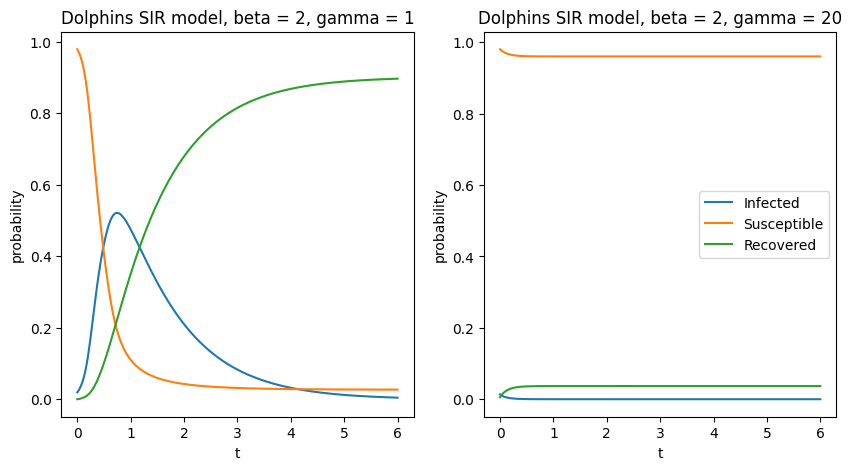

In [66]:
beta_list = [2,2]
gamma_list =  [1, 20]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
for index, ax in enumerate(axes.flatten()):
    # an example of a network with eigenvalue as the `gamma`
    history_I, history_S, history_R = SIR_model(beta_list[index], gamma_list[index], A1,N1, dt, time)
    ax.plot(time, history_I, label = 'Infected')
    ax.plot(time, history_S, label = 'Susceptible')
    ax.plot(time, history_R, label = 'Recovered')
    ax.set_xlabel('t')
    ax.set_ylabel('probability')
    ax.set_title(f'Dolphins SIR model, beta = {beta_list[index]}, gamma = {gamma_list[index]}')
plt.legend()
plt.show()

## Independent Cascade

The following function implements an influence cascade model on the graph `G` and initial active node set `x` with the same probability `p` to activate a neighbor node along each edge.

In [27]:
# G: Graph
# p: uniform probability to activate across an edge
# x: initial active seed set (as a list/array)
def influence_cascade(G,p,x):
    G = deepcopy(G)
    x = deepcopy(x)
    activated_nodes = set([])
    for i,xi in enumerate(x):
        if xi > 0:
            activated_nodes.add(G.node_by_index(i))

    while len(activated_nodes) > 0:
        newly_activated = set([])
        for u in activated_nodes:
            x[G.node_index(u)] = 1
            nbrs = G.neighbors(u)
            to_rm = set([])
            for v in nbrs:
                if random.random() <= p:
                    newly_activated.add(v)
                to_rm.add((u,v))
            G.remove_edges_from(to_rm)
        activated_nodes = newly_activated
        #print sum(x)
    return x


# percolation algorithm
def percolation(A, x, p=0.5):
    activated_nodes = []
    for i,xi in enumerate(x):
        if xi > 0:
            activated_nodes.append(i)
    all_edges = []
    for node_xi in activated_nodes:
        nbrs = where(A[:,node_xi])[0]
        for node_xj in nbrs:
            if (node_xj, node_xi) in all_edges:
                continue
            else:
                all_edges.append((node_xi, node_xj))
    # randomly select p% of the edges from all_edges
    rest_edges = random.sample(all_edges, int(len(all_edges)*p))

    # create a new empty graph
    G_new = nx.Graph()
    G_new.add_edges_from(rest_edges)

    # calculate the connected components
    connected_components = nx.connected_components(G_new)
    # flatten the connected components
    connected_components = [item for sublist in connected_components for item in sublist]
    final_x = zeros(len(x))
    for i in connected_components:
        final_x[int(i)] = 1
    return final_x


# percolation(A1 x, p=0.5)


### [8] three models together: independent cascade, percolation, SIR

[1 1 0 1 1 0 0 0 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 1 1 1 1 0
 1 0 1 1 1 0 1 1 1 1 0 1 0 0 1 0 1 0 0 0 0 0 1 0 1]


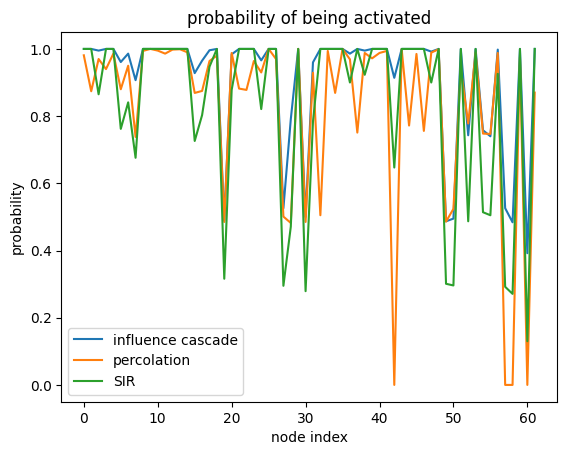

In [38]:
N = N1
A = A1
G = G1

# the random seed set
x = array([random.choice([0, 1]) for _ in range(N)])
print(x)


### The independent cascade model
prob_collection_cascade = zeros((1000, N))
for i in range(1000):
    # step 1: run influence cascade
    xx = influence_cascade(G, 0.5, x)
    # step 2: record the probability of being activated
    prob_collection_cascade[i] = xx

### The percolation model
prob_collection_percolation = zeros((1000, N))
for i in range(1000):
    # step 1: run influence cascade
    xx = percolation(A, x, p=0.5)
    # step 2: record the probability of being activated
    prob_collection_percolation[i] = xx


### The SIR of independent cascade model
beta = 1

prob_recovering = history_R[-1]

prob_SIR = 1- exp(-beta*prob_recovering)

### The independent cascade model
prob_collection_SIR = zeros((1000, N))
for i in range(1000):
    # step 1: run influence cascade
    xx = influence_cascade(G, p=prob_SIR, x=x)
    # step 2: record the probability of being activated
    prob_collection_SIR[i] = xx



plt.plot(mean(prob_collection_cascade, axis=0), label='influence cascade')
plt.plot(mean(prob_collection_percolation, axis=0), label='percolation')
plt.plot(mean(prob_collection_SIR, axis=0), label='SIR')
plt.xlabel('node index')
plt.ylabel('probability')
plt.title('probability of being activated')
plt.legend()
plt.show()
    